# LAB 4. CONSTRAINED OPTIMIZATION: EQUALITY CONSTRAINTS

## 2. SEQUENTIAL QUADRATIC PROGRAMMING

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_contour_gradients(f, gradf, xr=(-1,1.05) ,yr=(-1,1.05), step=0.05):
    # Clear plot
    plt.clf()
    
    # Create a mesh grid and apply the function over all the pairs of points
    X = np.arange(*xr, step)
    Y = np.arange(*yr, step)
    X, Y = np.meshgrid(X, Y)
    
    XY = np.c_[X.ravel(), Y.ravel()]
    Z = np.apply_along_axis(f, 1, XY).reshape(X.shape)

    # Plot contour of the function
    plt.figure()
    plt.contour(X, Y, Z, 50)

    # Get the gradient for each pair of points
    grad=np.apply_along_axis(gradf, 1, XY)
    
    # Plot the gradient
    plt.streamplot(X, Y, grad[:, 0].reshape(X.shape), grad[:, 1].reshape(X.shape))
    
    plt.show()

In this lab report, we will explore different approaches in order to solve a particular example of a nonlinear (equality) constrained problem. Since the optimum value that we are looking for is in general a saddle point of the Lagrangian and not a minimum, a gradient descent method applied to the Lagrangian would fail as we already know from previous experiments. 

In this case, we will use **sequential quadratic programming** where we basically use a quadratic approximation of the Lagrangian (Newton's method) and a linear approximation of the constraints to find a new search direction for each iteration by solving a linear system (the quadratic problem of each step).

Let us define the functions involved in the problem:

In [4]:
def f(x):
    return np.e**(3 * x[0]) + np.e**(-4 * x[1])

def h(x):
    return x[0]**2 + x[1]**2 - 1

def laplacian(x, lamb):
    return f(x) - lamb * h(x)

def grad_f(x):
    return np.array([3 * np.e**(3 * x[0]), -4 * np.e**(-4 * x[1])])

def grad_h(x):
    return np.array([2 * x[0], 2 * x[1]])

def grad_laplacian(x, lamb):
    return grad_f(x) - lamb * grad_h(x)

def hessian_f(x):
    return np.array([[9 * np.e**(3 * x[0]), 0], [0, 16 * np.e**(-4 * x[1])]])

def hessian_h():
    return np.array([[2, 0], [0, 2]])

def hessian_laplacian(x, lamb):
    return hessian_f(x) - lamb * hessian_h()

Before anything else, since plotting both functions $f$ and $h$ would become confusing easily (and we cannot plot the Lagrangian since our spatial dimension is two), we decided to plot the spatial paths that our next algorithms will follow along with the function $f$ contour lines in order to illustrate the process. But note that this is only a tool to visualize something and the values of $\lambda$ will just be shown numerically. Here we can also see the flux diagram of $f$, although we remark that this means nothing in terms of the constrained problem.

<Figure size 432x288 with 0 Axes>

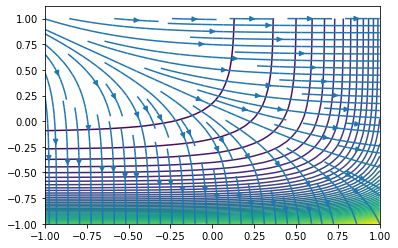

In [5]:
plot_contour_gradients(f, grad_f)

Now, we can define the sequential quadratic programming algorithm:

In [6]:
def construct_linear_system(x, lamb):
    leq_matrix = np.zeros((3, 3))
    
    der_h = grad_h(x)
    
    leq_matrix[:-1, :-1] = hessian_laplacian(x, lamb)
    leq_matrix[-1, :-1] = -der_h
    leq_matrix[:-1, -1] = -der_h
    
    rh_vector = np.zeros(3)
    
    rh_vector[:-1] = -grad_laplacian(x, lamb)
    rh_vector[-1] = h(x)
    
    return leq_matrix, rh_vector

In [7]:
def qop(x_0, lamb_0, alpha=1, epsilon=1e-5):
    x = np.copy(x_0)
    lamb = lamb_0
    
    x_path = [x]
    lamb_path = [lamb]
    
    while np.linalg.norm(grad_laplacian(x, lamb)) >= epsilon:
        leq_matrix, rh_vector = construct_linear_system(x, lamb)
        
        v_dir = np.linalg.solve(leq_matrix, rh_vector)
        
        x = x + alpha * v_dir[:-1]
        lamb += alpha * v_dir[-1]
        
        x_path.append(x)
        lamb_path.append(lamb)
        
    return x, lamb, np.array(x_path), np.array(lamb_path)

### Exercise 1

Let's check if we can arrive to the given solution of this problem,

$$x_1^*, x_2^* = (-0.74834, 0.66332)^T$$
$$\lambda^* = -0.21233,$$

if we use the same starting point proposed in the example $x=(-1,1)^T,\,\,\lambda=-1$ and a constant stepsize $\alpha_k=1$.

In [8]:
x = np.array([-1., 1.])
lamb = -1

In [9]:
x_end, lamb_end, _, _ = qop(x, lamb)

print(x_end, lamb_end)

[-0.74833818  0.66332345] -0.21232390186241443


Success!  👍

### Exercise 2

It is now time to see what happens if we start from poorer starting points, farther away from the optimal solution:

In [10]:
def plot_path(f, path, xr=(-5,1.05), yr=(-1.1,1.05), step=0.05, optimal=(-0.74834,0.66332)):
    # Clear plot
    plt.clf()
    
    # Create a mesh grid and apply the function over all the pairs of points
    X = np.arange(*xr, step)
    Y = np.arange(*yr, step)
    X, Y = np.meshgrid(X, Y)
    
    XY = np.c_[X.ravel(), Y.ravel()]
    Z = np.apply_along_axis(f, 1, XY).reshape(X.shape)

    # Plot contour of the function
    plt.figure()
    plt.contour(X, Y, Z, 50)
    
    # Plot optimal solution along with path to it
    plt.plot(path[:, 0], path[:, 1], 'ko-', label='Path')
    plt.scatter(optimal[0], optimal[1], c='orange', marker='*', label='Optimal')
    
    plt.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

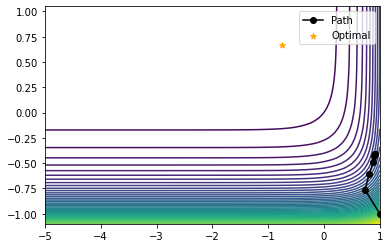

Starting point: [ 1. -1.]	Final point: [ 0.91041323 -0.41370007]
Starting lambda: -1	Final lambda: 25.293855202685933


<Figure size 432x288 with 0 Axes>

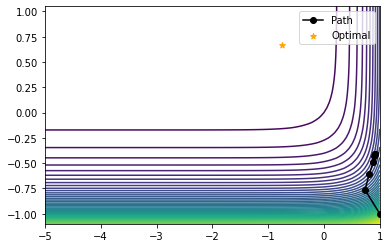

Starting point: [ 1. -1.]	Final point: [ 0.91041323 -0.41370007]
Starting lambda: -0.21232390186241443	Final lambda: 25.29385520271043


<Figure size 432x288 with 0 Axes>

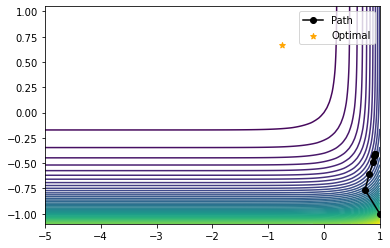

Starting point: [ 1. -1.]	Final point: [ 0.91041323 -0.41370007]
Starting lambda: 2	Final lambda: 25.293855202777692


<Figure size 432x288 with 0 Axes>

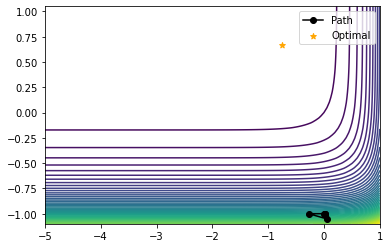

Starting point: [ 0. -1.]	Final point: [ 0.01434523 -0.9998971 ]
Starting lambda: -1	Final lambda: 109.16259801290026


<Figure size 432x288 with 0 Axes>

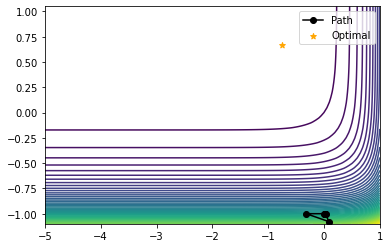

Starting point: [ 0. -1.]	Final point: [ 0.01434523 -0.9998971 ]
Starting lambda: -0.21232390186241443	Final lambda: 109.16259756189065


<Figure size 432x288 with 0 Axes>

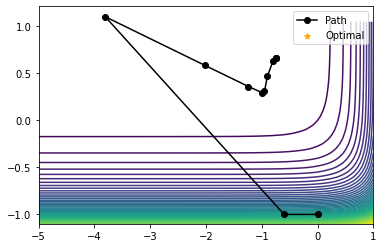

Starting point: [ 0. -1.]	Final point: [-0.74833549  0.66332044]
Starting lambda: 2	Final lambda: -0.21232493446893558


<Figure size 432x288 with 0 Axes>

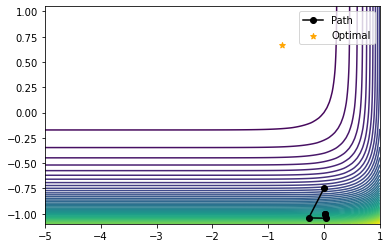

Starting point: [ 0.   -0.75]	Final point: [ 0.01434523 -0.9998971 ]
Starting lambda: -1	Final lambda: 109.1625976096965


<Figure size 432x288 with 0 Axes>

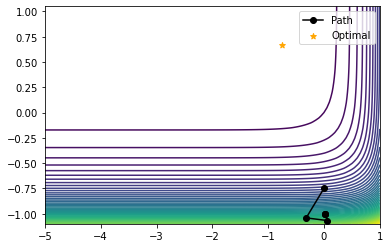

Starting point: [ 0.   -0.75]	Final point: [ 0.01434522 -0.99989712]
Starting lambda: -0.21232390186241443	Final lambda: 109.1626012724059


<Figure size 432x288 with 0 Axes>

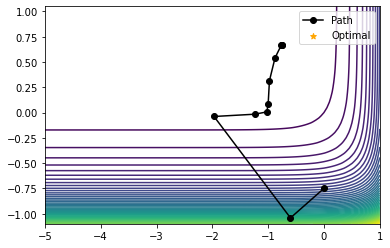

Starting point: [ 0.   -0.75]	Final point: [-0.74833589  0.6633201 ]
Starting lambda: 2	Final lambda: -0.21232469031790216


<Figure size 432x288 with 0 Axes>

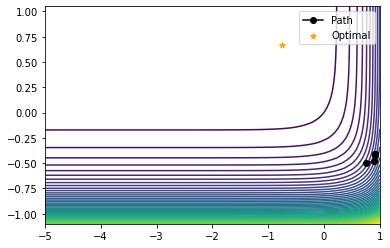

Starting point: [ 0.75 -0.5 ]	Final point: [ 0.91041323 -0.41370006]
Starting lambda: -1	Final lambda: 25.29385520417346


<Figure size 432x288 with 0 Axes>

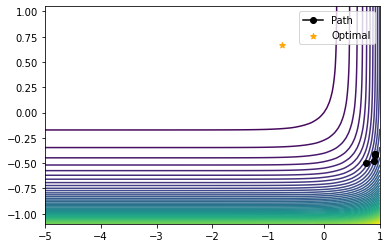

Starting point: [ 0.75 -0.5 ]	Final point: [ 0.91041323 -0.41370006]
Starting lambda: -0.21232390186241443	Final lambda: 25.29385520417471


<Figure size 432x288 with 0 Axes>

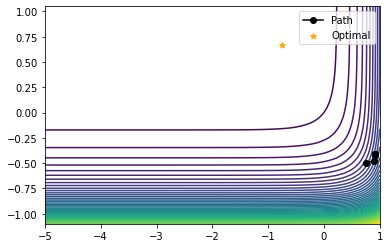

Starting point: [ 0.75 -0.5 ]	Final point: [ 0.91041323 -0.41370006]
Starting lambda: 2	Final lambda: 25.29385520417786


<Figure size 432x288 with 0 Axes>

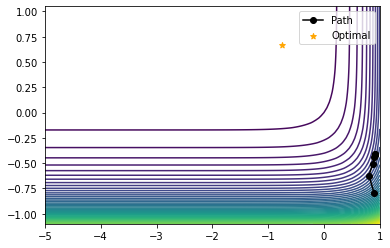

Starting point: [ 0.9 -0.8]	Final point: [ 0.91041323 -0.41370007]
Starting lambda: -1	Final lambda: 25.293855187987205


<Figure size 432x288 with 0 Axes>

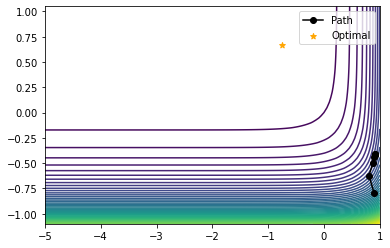

Starting point: [ 0.9 -0.8]	Final point: [ 0.91041323 -0.41370007]
Starting lambda: -0.21232390186241443	Final lambda: 25.293855188679427


<Figure size 432x288 with 0 Axes>

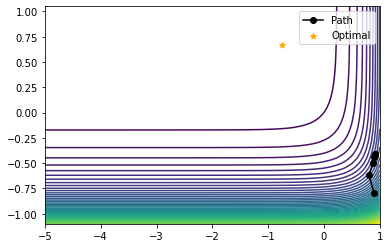

Starting point: [ 0.9 -0.8]	Final point: [ 0.91041323 -0.41370007]
Starting lambda: 2	Final lambda: 25.29385519050294


In [12]:
x_list = np.array([[1., -1.], [0., -1.], [0., -0.75], [0.75, -0.5], [0.9, -0.8]])
lamb_list = [-1, -0.21232390186241443, 2]

for x_0 in x_list:
    for lamb_0 in lamb_list:
        x_end, lamb_end, x_path, _ = qop(x_0, lamb_0)
        plot_path(f, x_path)
        print(f'Starting point: {x_0}\tFinal point: {x_end}')
        print(f'Starting lambda: {lamb_0}\tFinal lambda: {lamb_end}')

Indeed, in most cases (except two) we can't arrive to the solution and we may experience a divergence of the underneath Newton's method. We cannot even run the algorithm for $x_1, x_2 = (0, 0)$ because the linear system cannot be solved at that point (it's a singular matrix).


### Exercise 3

We are, thus, introduced to the idea of the merit function in order to change the function we want to optimize for another one that allows us to find an approximation of the (spatial) solution that we want.

In [11]:
def merit(x, rho=10):
    return f(x) + rho * h(x)


def grad_merit(x, rho=10):
    return grad_f(x) + 2 * rho * h(x) * grad_h(x)

In [12]:
def gradient_descent(x_0, g, grad_g, rho=10, tol=1e-5, normalize=False):
    x = x_0
    x_path = [x]
    alpha = 0.001
    
    while np.linalg.norm(grad_g(x, rho)) >= tol:        
        grad_g_val = grad_g(x, rho)
        
        if normalize:
            grad_g_val /= np.linalg.norm(grad_g_val)
        
        x = x - alpha * grad_g_val
        x_path.append(x)
    
    return x, x_path

The normalization of the gradient made it really hard to converge to a value near the optimal. Therefore, we haven't applied it. Using a classical gradient descent algorithm to our new merit function, we obtained the following results:

<Figure size 432x288 with 0 Axes>

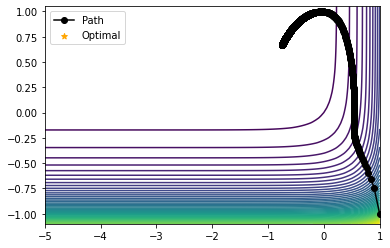

Starting point: [ 1. -1.]	Final point: [-0.75242478  0.66654823]


<Figure size 432x288 with 0 Axes>

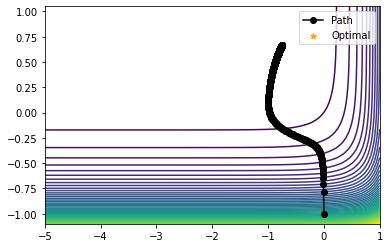

Starting point: [ 0. -1.]	Final point: [-0.7524339   0.66653795]


<Figure size 432x288 with 0 Axes>

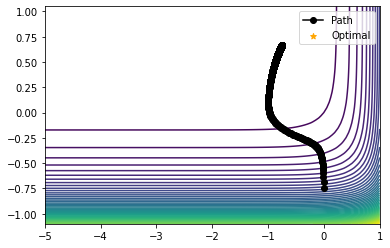

Starting point: [ 0.   -0.75]	Final point: [-0.7524339   0.66653796]


<Figure size 432x288 with 0 Axes>

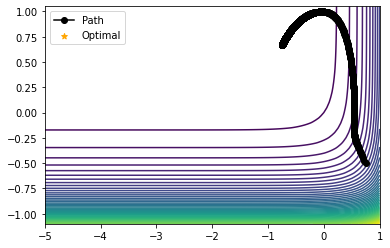

Starting point: [ 0.75 -0.5 ]	Final point: [-0.75242477  0.66654823]


<Figure size 432x288 with 0 Axes>

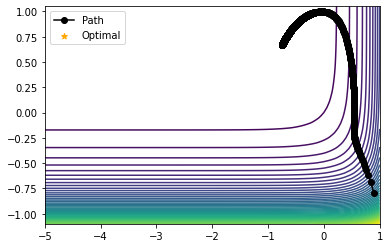

Starting point: [ 0.9 -0.8]	Final point: [-0.75242478  0.66654823]


In [13]:
for x_0 in x_list:
    x_end, x_path = gradient_descent(x_0, merit, grad_merit)
    plot_path(f, np.array(x_path))
    print(f'Starting point: {x_0}\tFinal point: {x_end}')

As we can see, the results are pretty good!

### Exercise 4

Finally, using the approximation found in the last exercise as our initial spatial point (with other random $\lambda$ value), we can now make use of the Newton-based method to find the optimal solution:

In [14]:
def plot_combined_path(f, merit_path, newton_path, xr=(-5,1.05), yr=(-1.1,1.05),
                       step=0.05, optimal=(-0.74834,0.66332)):
    # Clear plot
    plt.clf()
    
    # Create a mesh grid and apply the function over all the pairs of points
    X = np.arange(*xr, step)
    Y = np.arange(*yr, step)
    X, Y = np.meshgrid(X, Y)
    
    XY = np.c_[X.ravel(), Y.ravel()]
    Z = np.apply_along_axis(f, 1, XY).reshape(X.shape)

    # Plot contour of the function
    plt.figure()
    plt.contour(X, Y, Z, 50)
    
    # Plot optimal solution along with paths to it
    plt.plot(merit_path[:, 0], merit_path[:, 1], 'ro-', label='Merit')
    plt.plot(newton_path[:, 0], newton_path[:, 1], 'bo-', label='Newton')
    plt.scatter(optimal[0], optimal[1], c='orange', marker='*', label='Optimal')
    
    plt.legend()
    plt.show()    

In [15]:
def qop_merit(x_0, lamb_0, g, grad_g, rho=10, tol=1e-5, normalize=False):
    x, x_path_merit = gradient_descent(x_0, g, grad_g, rho, tol, normalize)
    x, lamb, x_path_qop, lamb_path = qop(x, lamb_0, epsilon=tol)
    
    return x, lamb, np.array(x_path_merit), np.array(x_path_qop), lamb_path

<Figure size 432x288 with 0 Axes>

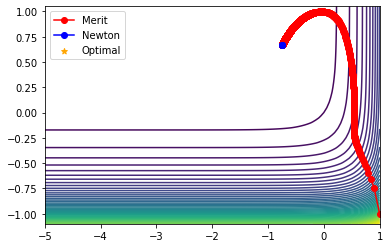

Starting point: [ 1. -1.]	Final point: [-0.74833606  0.66331981]
Starting lambda: -1	Final lambda: -0.21232500268673524


<Figure size 432x288 with 0 Axes>

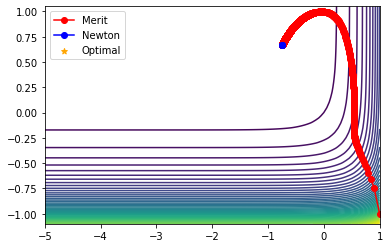

Starting point: [ 1. -1.]	Final point: [-0.74833549  0.66332043]
Starting lambda: -0.21232390186241443	Final lambda: -0.21232493501483163


<Figure size 432x288 with 0 Axes>

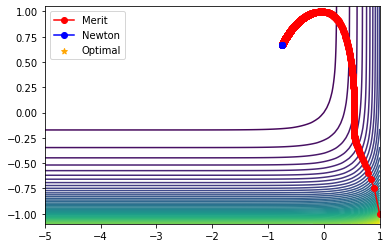

Starting point: [ 1. -1.]	Final point: [-0.74833549  0.66332043]
Starting lambda: 2	Final lambda: -0.21232493550295337


<Figure size 432x288 with 0 Axes>

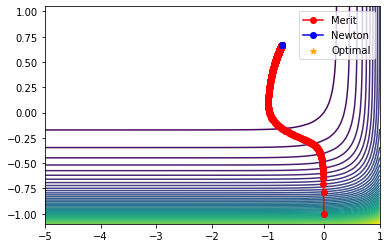

Starting point: [ 0. -1.]	Final point: [-0.74833608  0.66331978]
Starting lambda: -1	Final lambda: -0.21232500215661493


<Figure size 432x288 with 0 Axes>

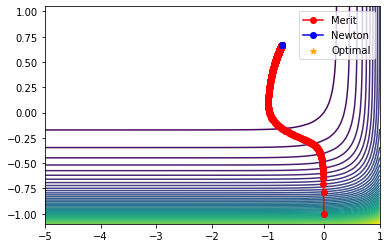

Starting point: [ 0. -1.]	Final point: [-0.74833549  0.66332043]
Starting lambda: -0.21232390186241443	Final lambda: -0.21232493501505165


<Figure size 432x288 with 0 Axes>

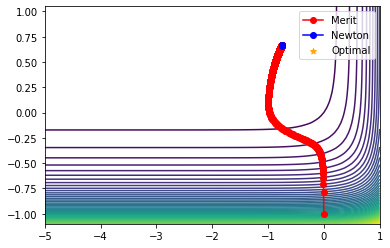

Starting point: [ 0. -1.]	Final point: [-0.74833549  0.66332043]
Starting lambda: 2	Final lambda: -0.21232493549853332


<Figure size 432x288 with 0 Axes>

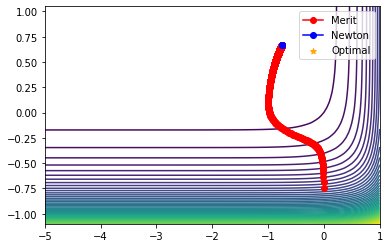

Starting point: [ 0.   -0.75]	Final point: [-0.74833608  0.66331978]
Starting lambda: -1	Final lambda: -0.21232500215678607


<Figure size 432x288 with 0 Axes>

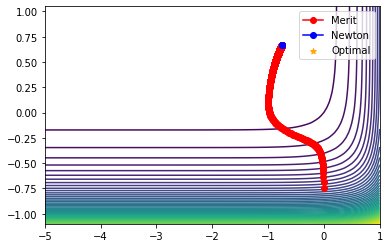

Starting point: [ 0.   -0.75]	Final point: [-0.74833549  0.66332043]
Starting lambda: -0.21232390186241443	Final lambda: -0.21232493501505167


<Figure size 432x288 with 0 Axes>

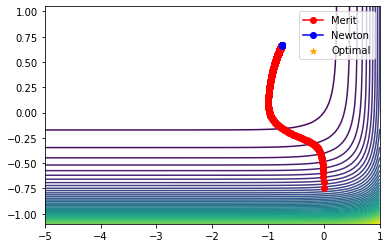

Starting point: [ 0.   -0.75]	Final point: [-0.74833549  0.66332043]
Starting lambda: 2	Final lambda: -0.2123249354985347


<Figure size 432x288 with 0 Axes>

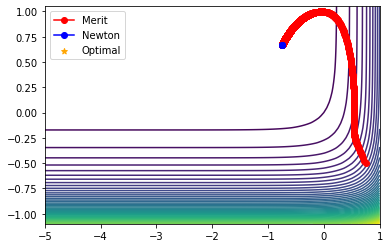

Starting point: [ 0.75 -0.5 ]	Final point: [-0.74833606  0.66331981]
Starting lambda: -1	Final lambda: -0.21232500268693585


<Figure size 432x288 with 0 Axes>

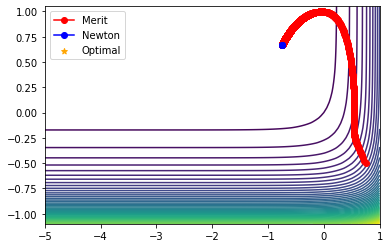

Starting point: [ 0.75 -0.5 ]	Final point: [-0.74833549  0.66332043]
Starting lambda: -0.21232390186241443	Final lambda: -0.21232493501483155


<Figure size 432x288 with 0 Axes>

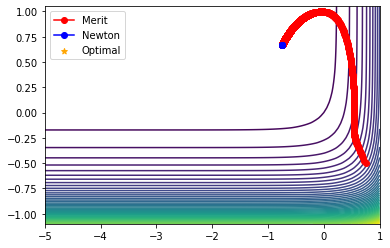

Starting point: [ 0.75 -0.5 ]	Final point: [-0.74833549  0.66332043]
Starting lambda: 2	Final lambda: -0.2123249355029551


<Figure size 432x288 with 0 Axes>

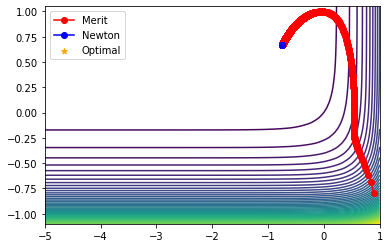

Starting point: [ 0.9 -0.8]	Final point: [-0.74833606  0.66331981]
Starting lambda: -1	Final lambda: -0.21232500268676438


<Figure size 432x288 with 0 Axes>

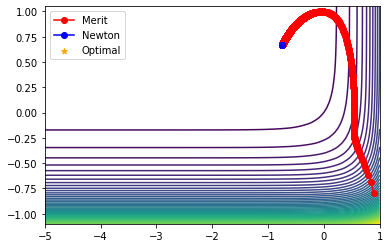

Starting point: [ 0.9 -0.8]	Final point: [-0.74833549  0.66332043]
Starting lambda: -0.21232390186241443	Final lambda: -0.21232493501483166


<Figure size 432x288 with 0 Axes>

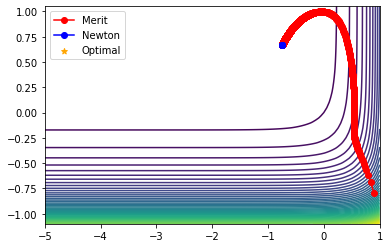

Starting point: [ 0.9 -0.8]	Final point: [-0.74833549  0.66332043]
Starting lambda: 2	Final lambda: -0.21232493550295356


In [16]:
for x_0 in x_list:
    for lamb_0 in lamb_list:
        x_end, lamb_end, merit_path, newton_path, _ = qop_merit(x_0, lamb_0, merit, grad_merit)
        plot_combined_path(f, merit_path, newton_path)
        print(f'Starting point: {x_0}\tFinal point: {x_end}')
        print(f'Starting lambda: {lamb_0}\tFinal lambda: {lamb_end}')

Overall, we end up finding values that resemble greatly the optimal solution for the constrained optimization problem. We can say that global convergence is guaranteed!